In [111]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import glob


# clustering and dimension reduction
from sklearn.cluster import KMeans
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.decomposition import PCA
from  sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cityblock

# for everything else
import os
import cv2 as cv 
from skimage import io
from PIL import Image 

#import pickle

from numpy import genfromtxt

from random import randint
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

# Carga lista de archivos

In [7]:
lista_archivos=glob.glob(r"C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\arroz\Rice_Image_Dataset/**/*.jpg", recursive = True)

In [8]:
len(lista_archivos)

75000

In [9]:
df=pd.DataFrame({"Archivo":lista_archivos})

In [10]:
df

Archivo
0      C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
1      C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
2      C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
3      C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
4      C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
...                                                  ...
74995  C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
74996  C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
74997  C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
74998  C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...
74999  C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\a...

[75000 rows x 1 columns]

In [11]:
df["label"]=np.where(df.Archivo.str.contains("Arborio"),"Arborio",None)
df["label"]=np.where(df.Archivo.str.contains("Basmati"),"Basmati",df["label"])
df["label"]=np.where(df.Archivo.str.contains("Ipsala"),"Ipsala",df["label"])
df["label"]=np.where(df.Archivo.str.contains("Jasmine"),"Jasmine",df["label"])
df["label"]=np.where(df.Archivo.str.contains("Karacadag"),"Karacadag",df["label"])

In [12]:
df.label.value_counts().sort_index()

Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: label, dtype: int64

In [13]:
df=df[df["label"].str.match( "Karacadag|Jasmine|Ipsala")]

In [14]:
df.label.value_counts()

Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: label, dtype: int64

# Cargar features

In [15]:
names_pd = pd.read_csv(r'C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\arroz\Rice_Image_Dataset\names_pd.csv', index_col=0)

In [16]:
names = names_pd.to_numpy()

In [17]:
feat_pd = pd.read_csv(r"C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\arroz\Rice_Image_Dataset\feat_pd.csv", index_col=0)

In [18]:
feat_pd=feat_pd.iloc[df.index]

In [19]:
feat = feat_pd.to_numpy()

In [20]:
feat.shape

(45000, 4096)

In [21]:
label = df['label'].tolist()
unique_labels = list(set(label))

# Tomar muestra para trabajar

In [22]:
X_train, X_test, y_train, y_test = train_test_split( feat, df, test_size=0.0666666666666, random_state=42, stratify=df.label)

In [23]:
feat = X_test
df = y_test

In [24]:
feat.shape

(3000, 4096)

# KMEAN 

In [231]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(feat)
labels_cluster=kmeans.labels_

In [232]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [233]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala      19   12  969
Jasmine      3  978   19
Karacadag  987    1   12

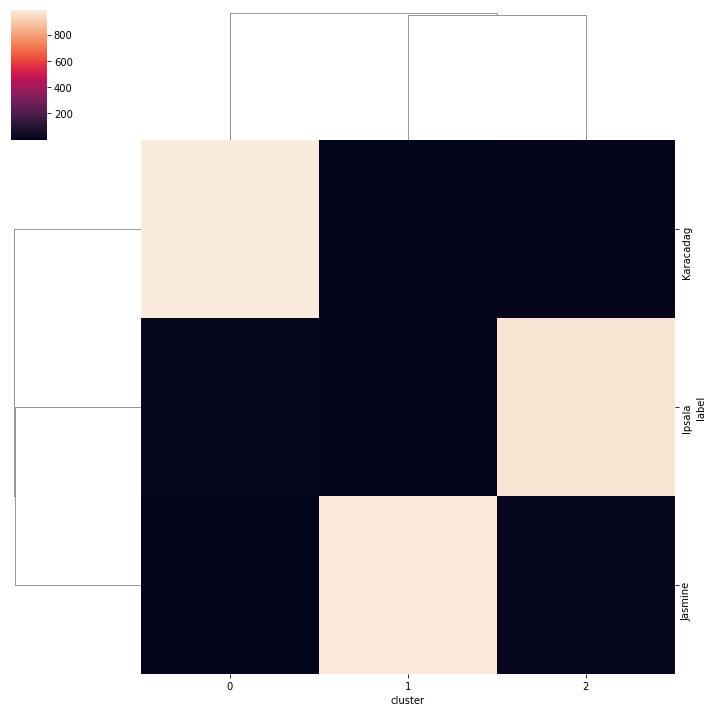

In [234]:
sns.clustermap(confusion)

In [235]:
print(vanDongen(confusion))

0.033074417439238286


In [236]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9352341838967526


In [237]:
silhouette_score(feat, labels_cluster)

0.18032270832084804

In [238]:
kmeans.inertia_

3030030.204394219

## buscando nro clusters optimo

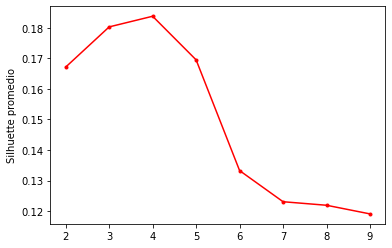

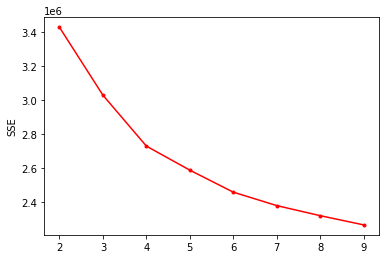

In [67]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat)

    silh.append(silhouette_score(feat, KM.labels_)) #, metric='precomputed'
    sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

El optimo es 4

In [239]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(feat)
labels_cluster=kmeans.labels_

In [240]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [241]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala      11    7  499  483
Jasmine      0  738    7  255
Karacadag  984    2   11    3

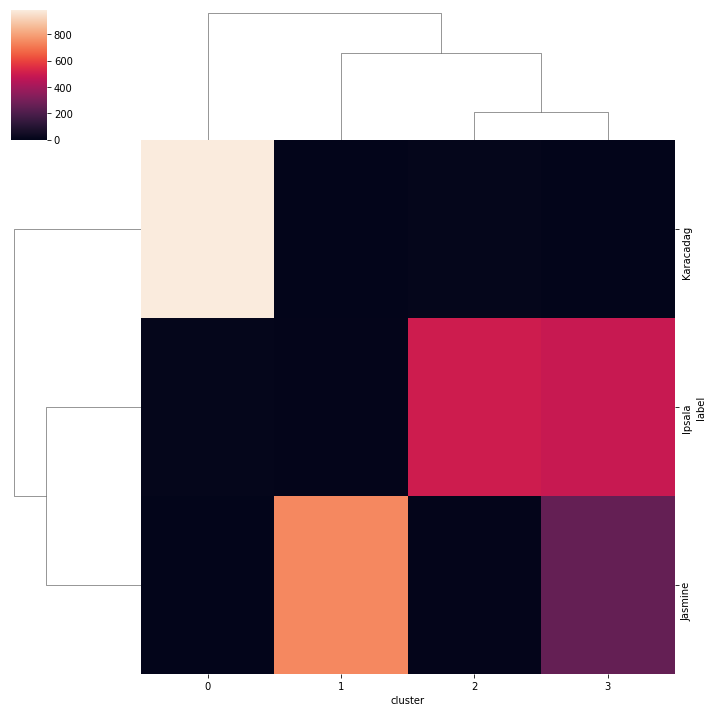

In [242]:
sns.clustermap(confusion)

In [243]:
print(vanDongen(confusion))

0.26841448189762795


In [244]:
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6715436221649682


In [245]:
silhouette_score(feat, labels_cluster)

0.18381329729223603

In [246]:
kmeans.inertia_

2730102.642915928

## Visualizacion de cluster usando PCA

In [73]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

In [74]:
scores .shape

(3000, 100)

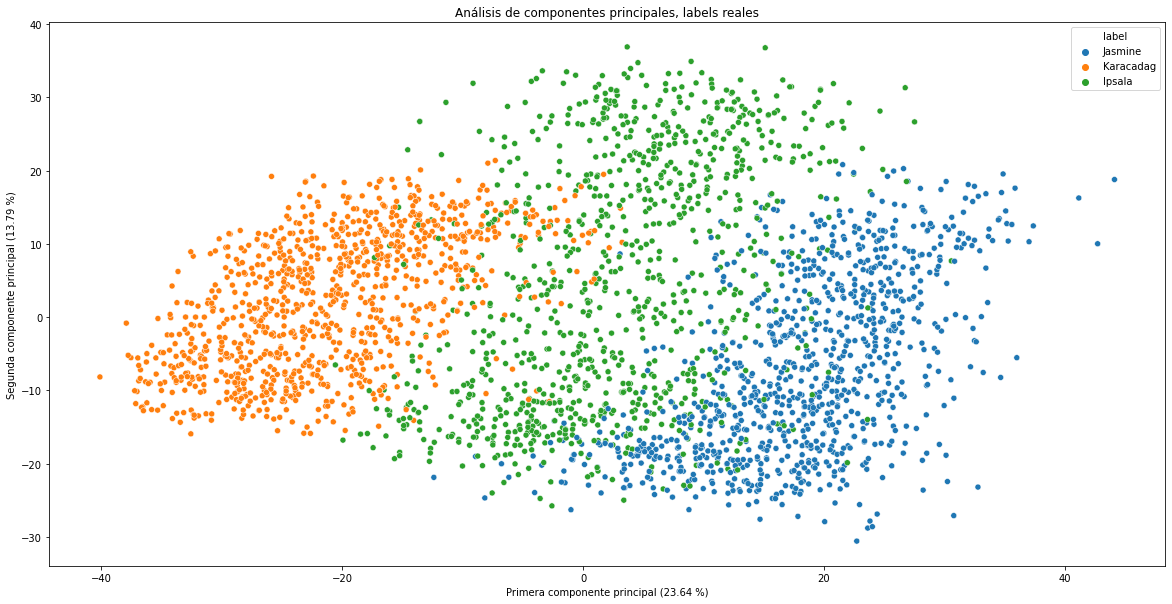

In [75]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

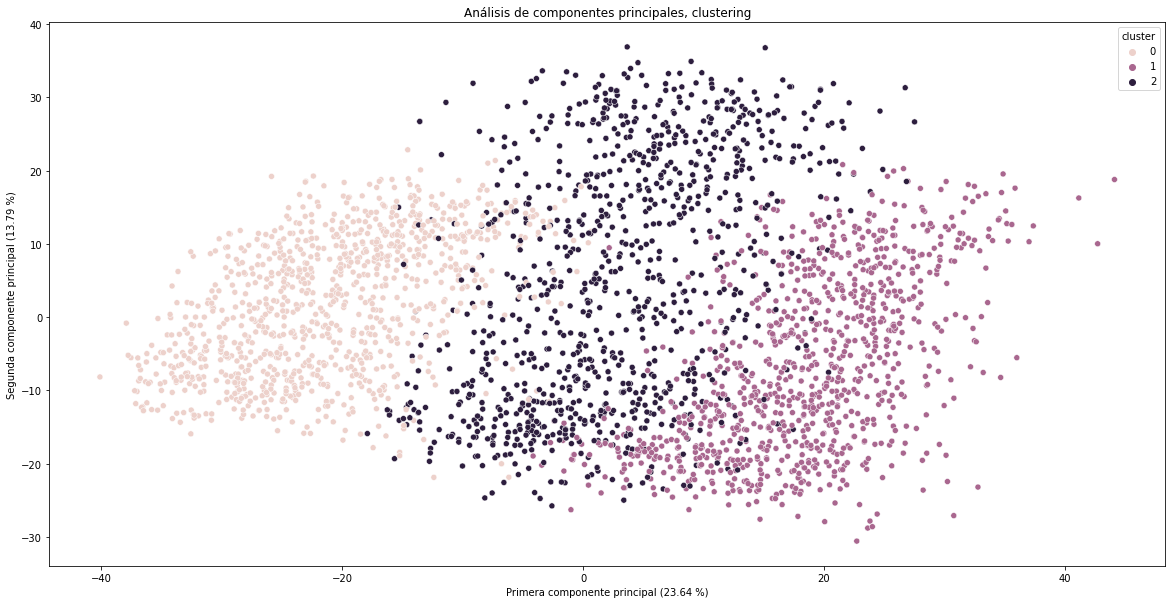

In [76]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# KMEAN normalizado

In [247]:
scaler = MinMaxScaler()
feat_norm=scaler.fit_transform(feat)

In [248]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(feat_norm)
labels_cluster=kmeans.labels_

In [249]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [250]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala       4  984   12
Jasmine      1   16  983
Karacadag  992    7    1

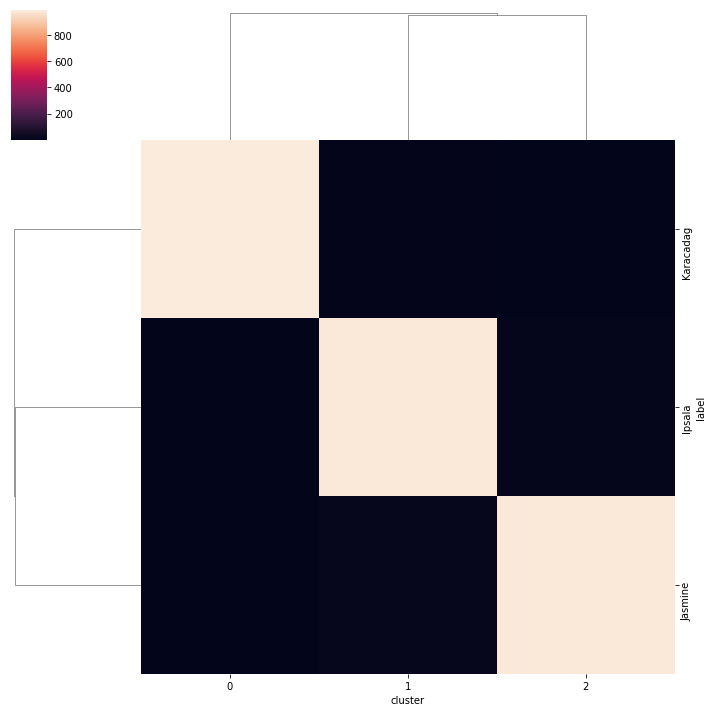

In [251]:
sns.clustermap(confusion)

In [252]:
print(vanDongen(confusion))

0.02053593789130979


In [253]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9594927362808686


In [254]:
silhouette_score(feat_norm, labels_cluster)

0.1518197333247302

In [255]:
kmeans.inertia_

149691.88894185654

## buscando nro clusters optimo

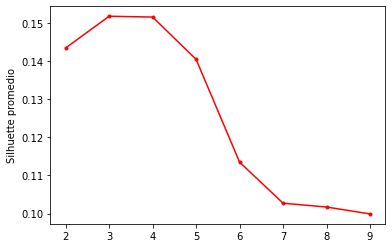

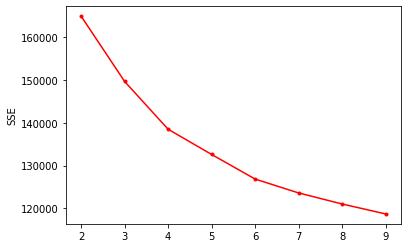

In [256]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat_norm)

    silh.append(silhouette_score(feat_norm, KM.labels_)) #, metric='precomputed'
    sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

El optimo es 3

In [268]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(feat_norm)
labels_cluster=kmeans.labels_

In [269]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [270]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala     521    6   10  463
Jasmine      9  735    0  256
Karacadag    8    1  988    3

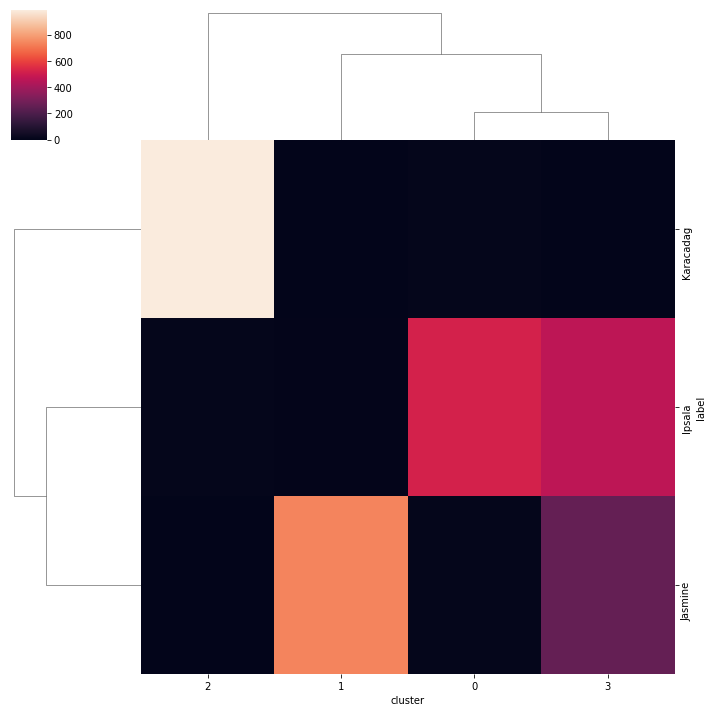

In [271]:
sns.clustermap(confusion)

In [272]:
print(vanDongen(confusion))

0.2621189405297351


In [273]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.677149171469929


In [275]:
silhouette_score(feat_norm, labels_cluster)

0.15136927442766243

In [276]:
kmeans.inertia_

138511.91776074455

## Visualizacion de cluster usando PCA

In [89]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat_norm)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

In [90]:
scores .shape

(3000, 100)

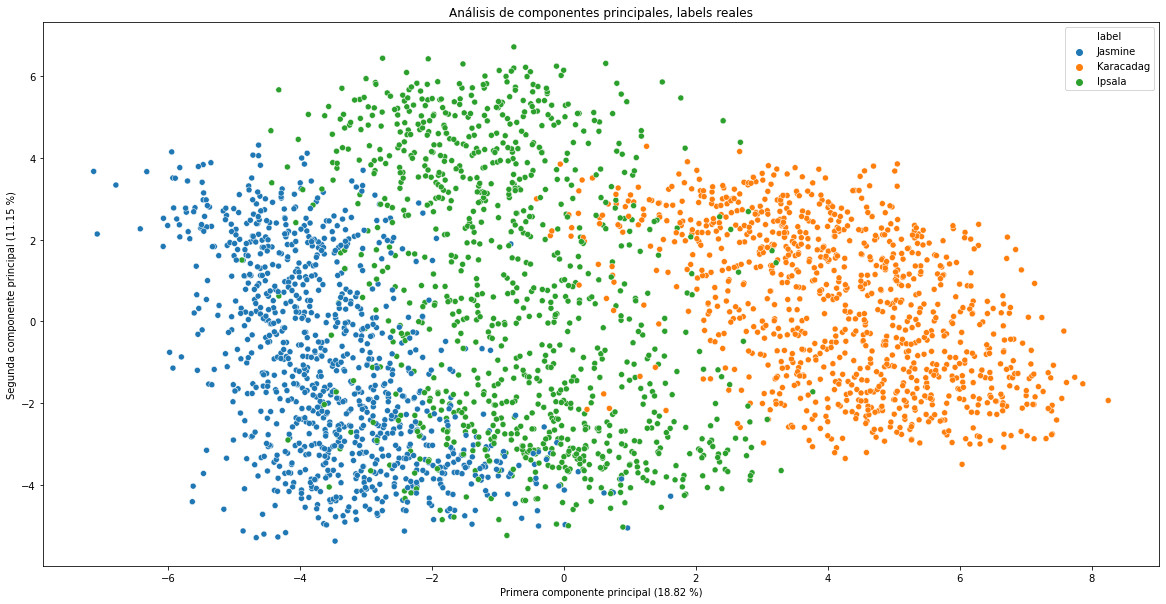

In [91]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

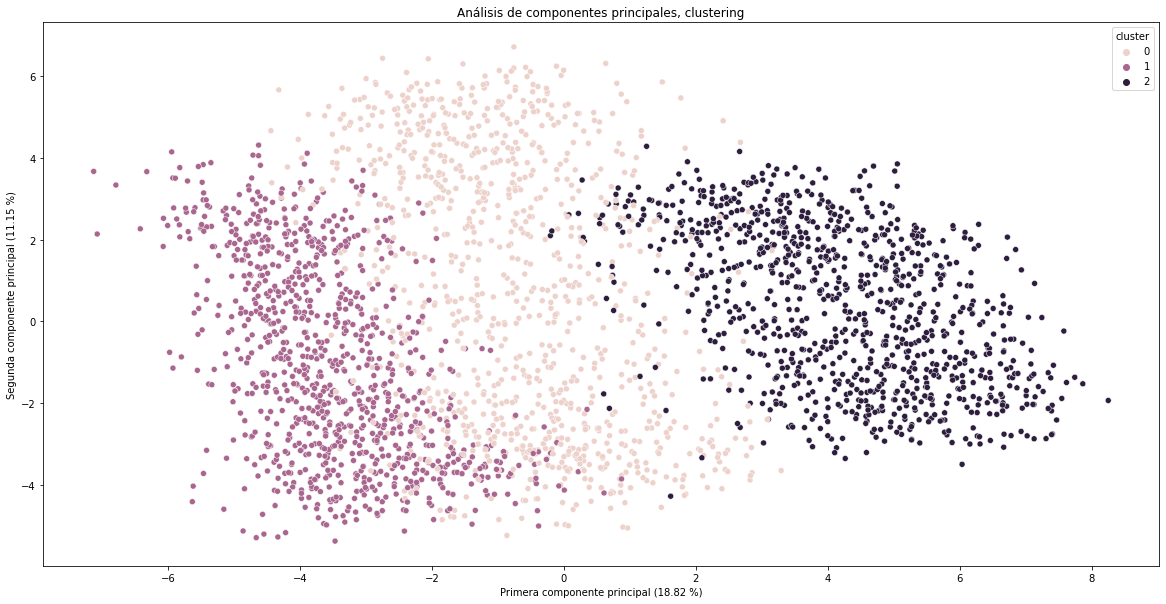

In [92]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# KMEAN escalado

In [277]:
scaler = StandardScaler()
feat_stdsc=scaler.fit_transform(feat)

In [278]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(feat_stdsc)
labels_cluster=kmeans.labels_

In [279]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [280]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala      10    4  986
Jasmine    984    1   15
Karacadag    1  997    2

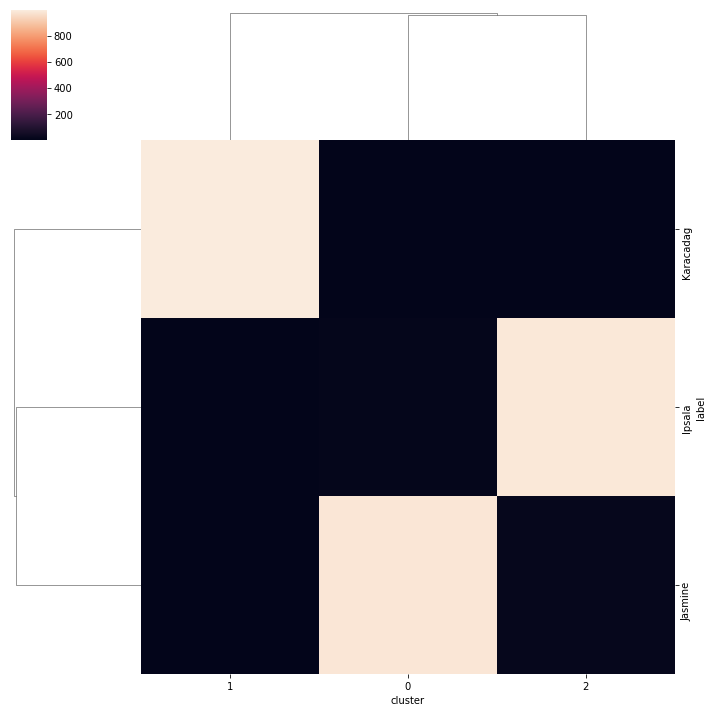

In [281]:
sns.clustermap(confusion)

In [282]:
print(vanDongen(confusion))

0.01651238428821616


In [283]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9673728447674116


In [284]:
silhouette_score(feat_stdsc, labels_cluster)

0.10291859200940011

In [285]:
kmeans.inertia_

8922008.57752264

## buscando nro clusters optimo

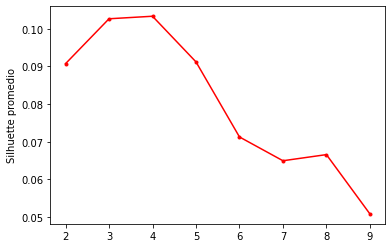

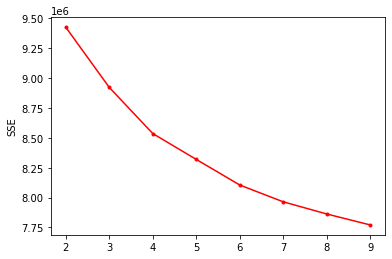

In [286]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat_stdsc)

    silh.append(silhouette_score(feat_stdsc, KM.labels_)) #, metric='precomputed'
    sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

El optimo es 4

In [287]:
kmeans = KMeans(n_clusters=4, max_iter=300)
kmeans.fit(feat_stdsc)
labels_cluster=kmeans.labels_

In [288]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [289]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala       7   11  474  508
Jasmine    744    0  247    9
Karacadag    1  991    3    5

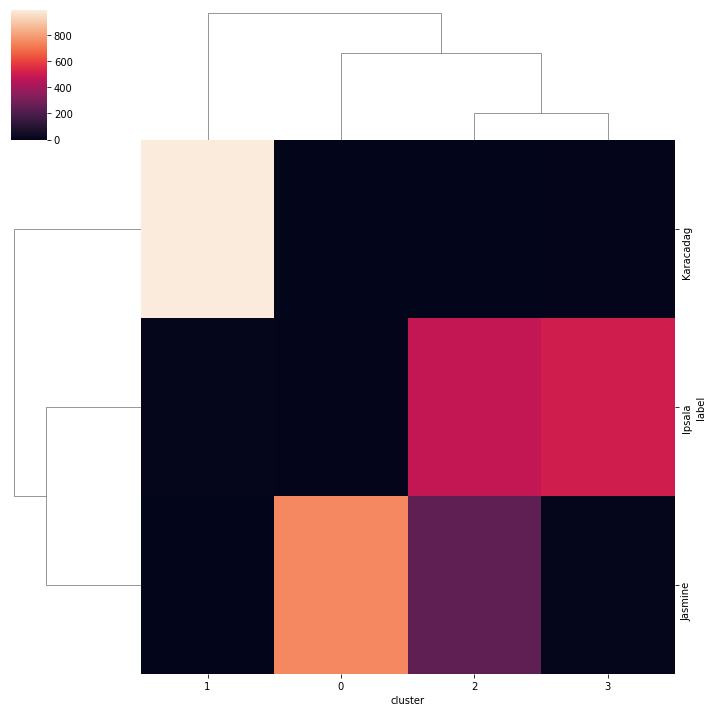

In [290]:
sns.clustermap(confusion)

In [291]:
print(vanDongen(confusion))

0.26013006503251623


In [292]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6812107065127564


In [293]:
silhouette_score(feat_stdsc, labels_cluster)

0.10336114504723087

In [294]:
kmeans.inertia_

8535837.422859943

## Visualizacion de cluster usando PCA

In [106]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat_stdsc)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

In [107]:
scores .shape

(3000, 100)

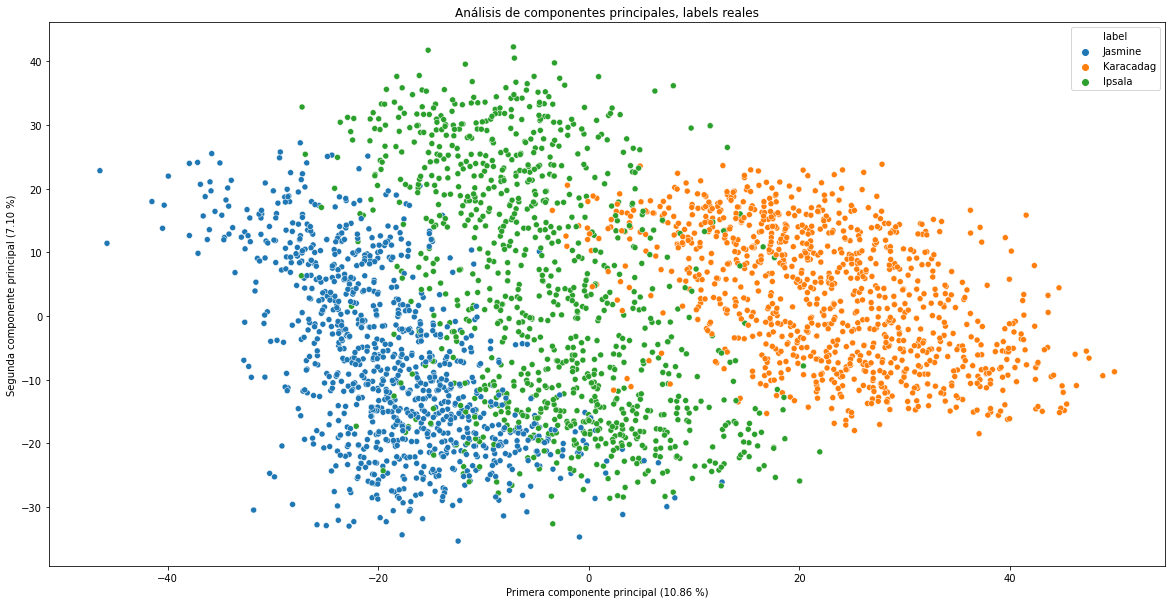

In [108]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

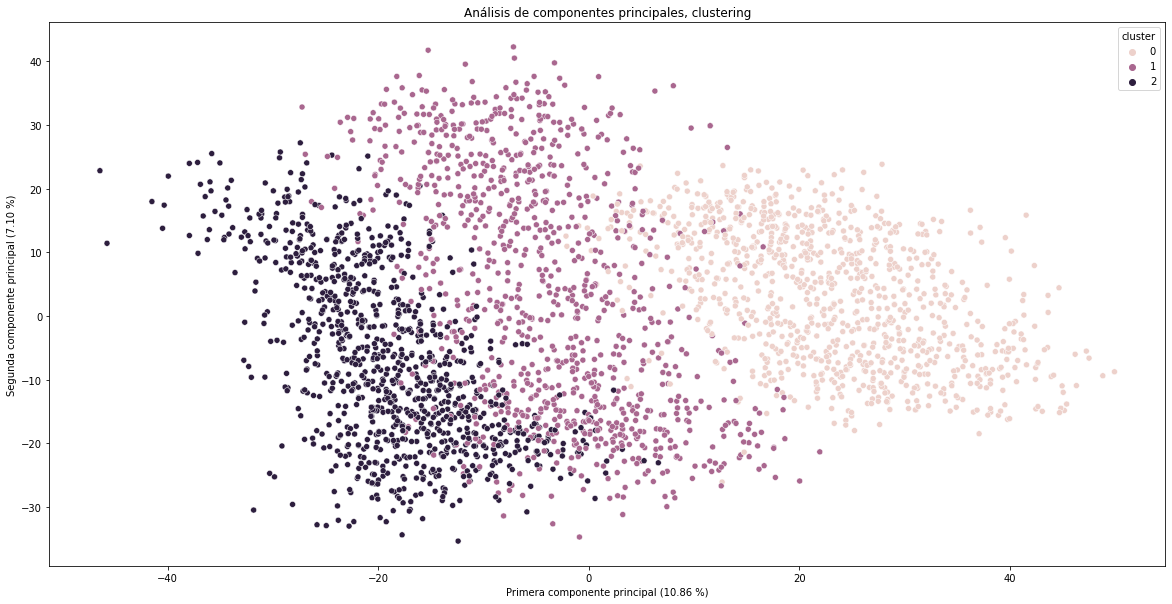

In [109]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# NLTK euclidean distance


In [295]:
clusterer = KMeansClusterer(num_means=3, distance=euclidean_distance)
labels_cluster = clusterer.cluster(feat, True, trace=True)
#centroids = clusterer._centroid

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [167]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [168]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala      12  967   21
Jasmine    979   18    3
Karacadag    1   12  987

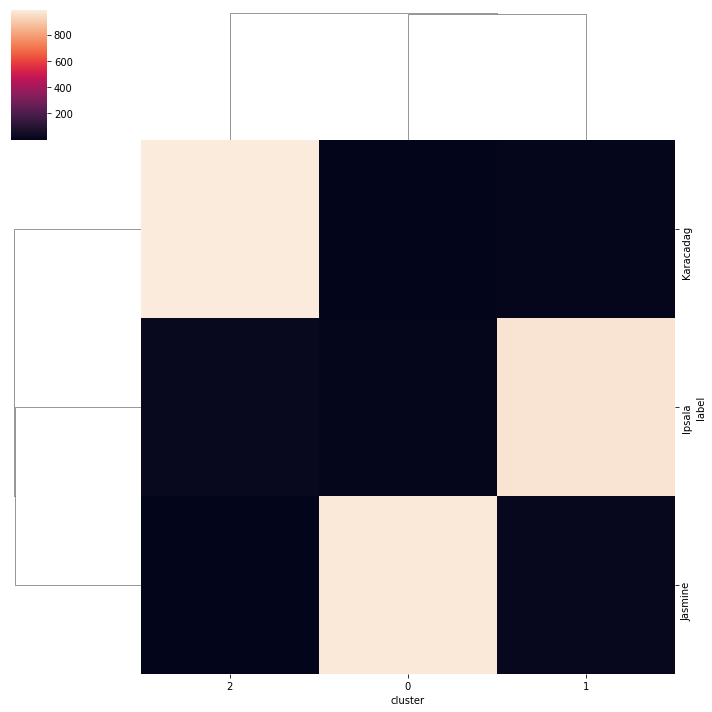

In [169]:
sns.clustermap(confusion)

In [170]:
print(vanDongen(confusion))

0.033592379042366505


In [171]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9342897422871026


In [172]:
silhouette_score(feat, labels_cluster)

0.18038827093311532

## buscando nro clusters optimo

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iter

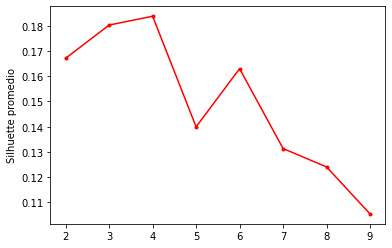

In [165]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat)
    clusterer = KMeansClusterer(num_means=k, distance=euclidean_distance)
    labels_cluster_k = clusterer.cluster(feat, True, trace=True)

    silh.append(silhouette_score(feat,  labels_cluster_k  )) #, metric='precomputed'
    #sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

#plt.plot(range_k,sse,'r.-')
#plt.ylabel('SSE')
#plt.show()

El optimo es 4

In [303]:
clusterer = KMeansClusterer(num_means=4, distance=euclidean_distance)
labels_cluster = clusterer.cluster(feat, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [304]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala      10    7  513  470
Jasmine      0  735    7  258
Karacadag  984    2   11    3

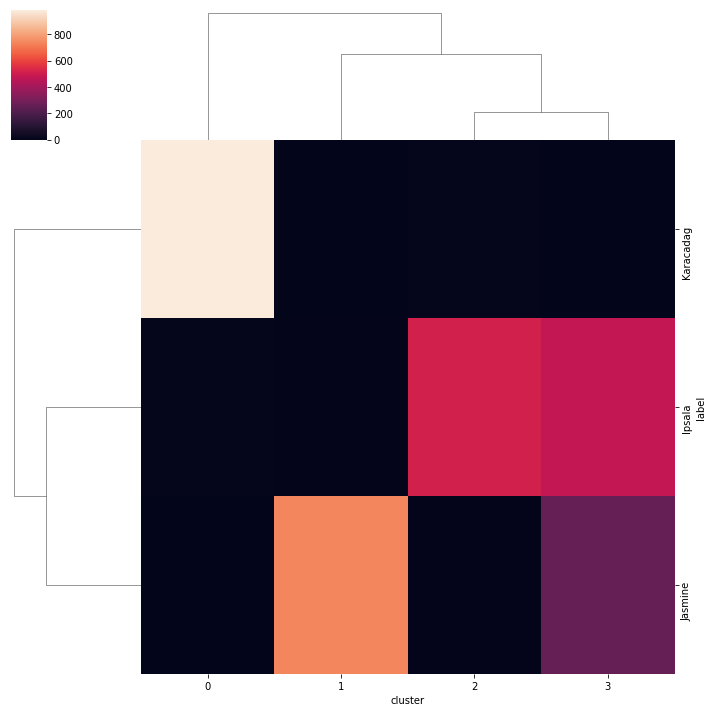

In [305]:
sns.clustermap(confusion)

In [306]:
print(vanDongen(confusion))

0.26610084872690964


In [307]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6724826356684858


In [308]:
silhouette_score(feat, labels_cluster)

0.18347117018242204

## Visualizacion de cluster usando PCA

In [173]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

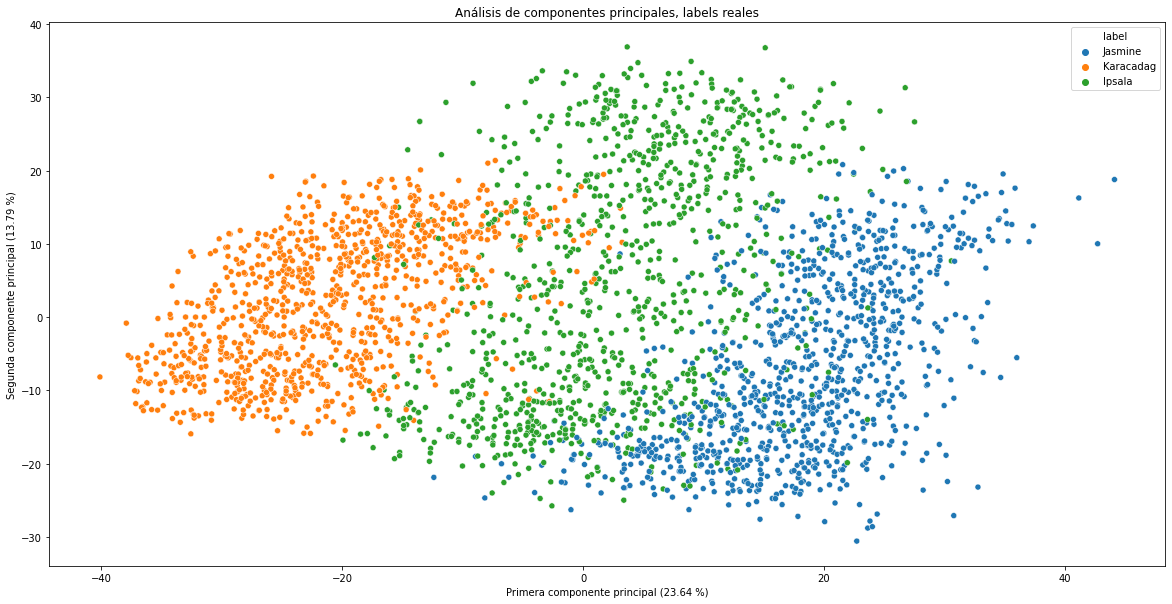

In [174]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

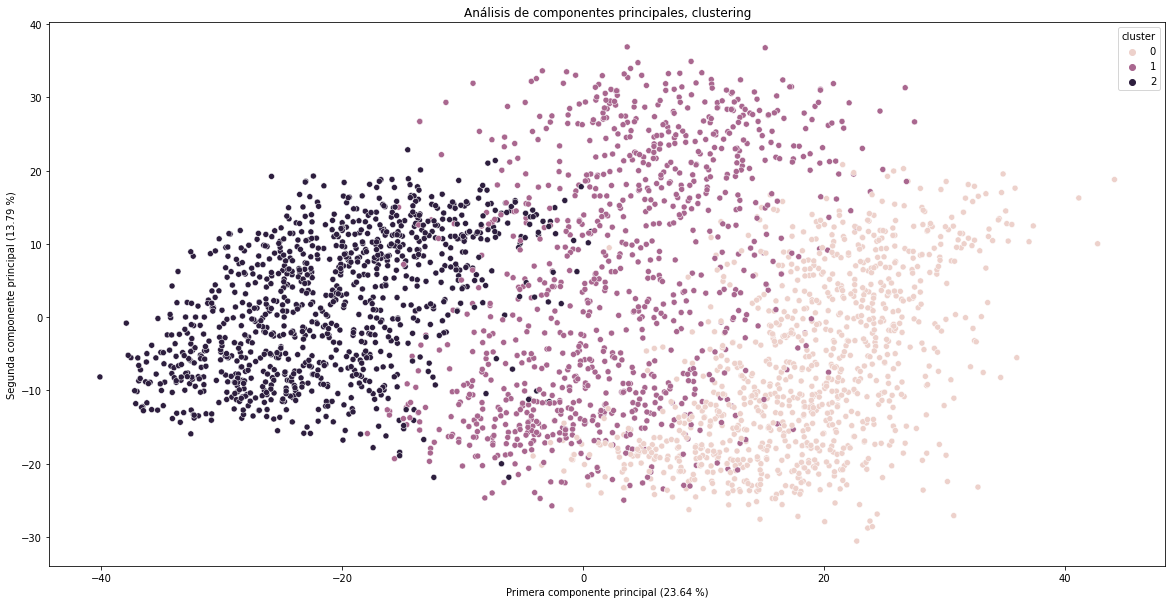

In [175]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# NLKT cosine distance

In [176]:
clusterer = KMeansClusterer(num_means=3, distance=cosine_distance)
labels_cluster = clusterer.cluster(feat, True, trace=True)
#centroids = clusterer._centroid

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [177]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [178]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala     499  467   34
Jasmine    613  387    0
Karacadag    3   23  974

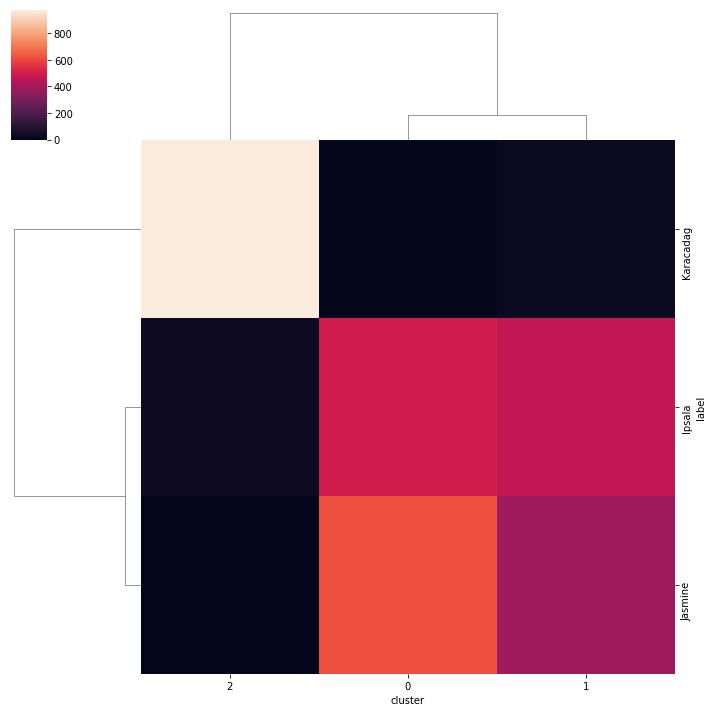

In [179]:
sns.clustermap(confusion)

In [180]:
print(vanDongen(confusion))

0.47876447876447875


In [181]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.4653058521215136


In [182]:
silhouette_score(feat, labels_cluster)

0.16903999935265812

## buscando nro clusters optimo

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iter

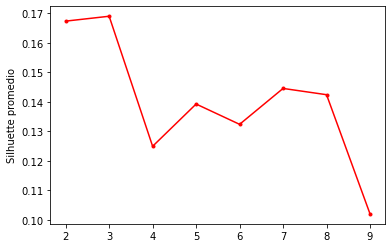

In [156]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat)
    clusterer = KMeansClusterer(num_means=k, distance=cosine_distance)
    labels_cluster_k = clusterer.cluster(feat, True, trace=True)

    silh.append(silhouette_score(feat,  labels_cluster_k  )) #, metric='precomputed'
    #sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

#plt.plot(range_k,sse,'r.-')
#plt.ylabel('SSE')
#plt.show()

El optimo es 3 

## Visualizacion de cluster usando PCA

In [ ]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# NLKT cityblock distance

In [309]:
clusterer = KMeansClusterer(num_means=3, distance=cityblock)
labels_cluster = clusterer.cluster(feat, True, trace=True)
#centroids = clusterer._centroid

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [310]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [311]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala     945   30   25
Jasmine      4    3  993
Karacadag    6  993    1

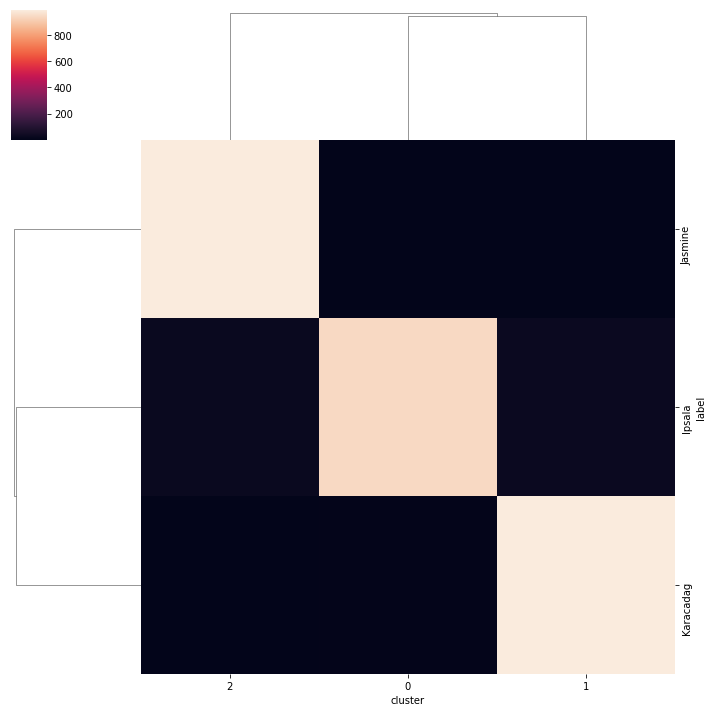

In [312]:
sns.clustermap(confusion)

In [313]:
print(vanDongen(confusion))

0.034725717161550075


In [314]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9325617571234224


In [315]:
silhouette_score(feat, labels_cluster)

0.1810056580377893

## buscando nro clusters optimo

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


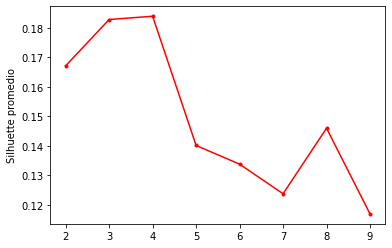

In [360]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat)
    clusterer = KMeansClusterer(num_means=k, distance=cityblock)
    labels_cluster_k = clusterer.cluster(feat, True, trace=True)

    silh.append(silhouette_score(feat,  labels_cluster_k  )) #, metric='precomputed'
    #sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

#plt.plot(range_k,sse,'r.-')
#plt.ylabel('SSE')
#plt.show()

El optimo es 4 

In [317]:
clusterer = KMeansClusterer(num_means=4, distance=cityblock)
labels_cluster = clusterer.cluster(feat, True, trace=True)
#centroids = clusterer._centroid

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [318]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala     500   12    8  480
Jasmine      5    0  757  238
Karacadag   10  985    2    3

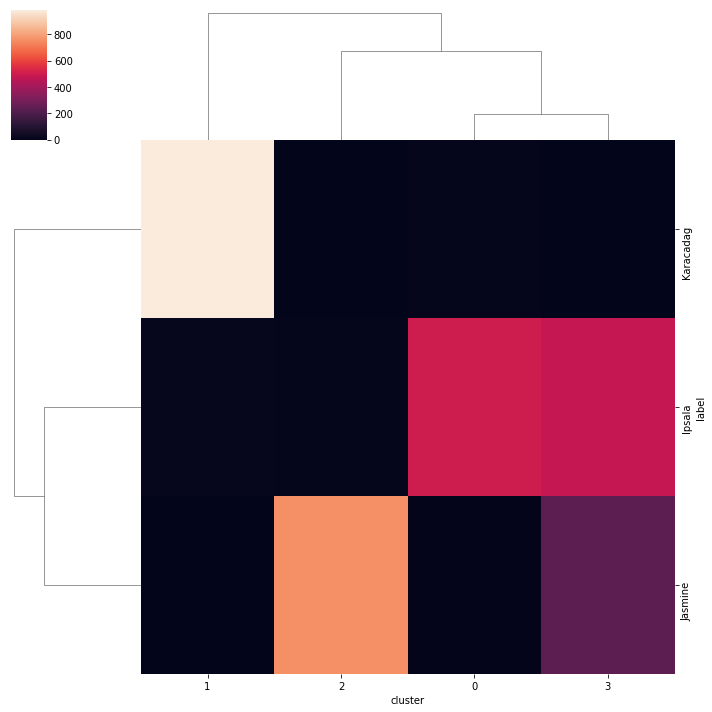

In [319]:
sns.clustermap(confusion)

In [320]:
print(vanDongen(confusion))

0.25880589557831624


In [321]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6814630088504487


In [322]:
silhouette_score(feat, labels_cluster)

0.1839439582193703

## Visualizacion de cluster usando PCA

In [190]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

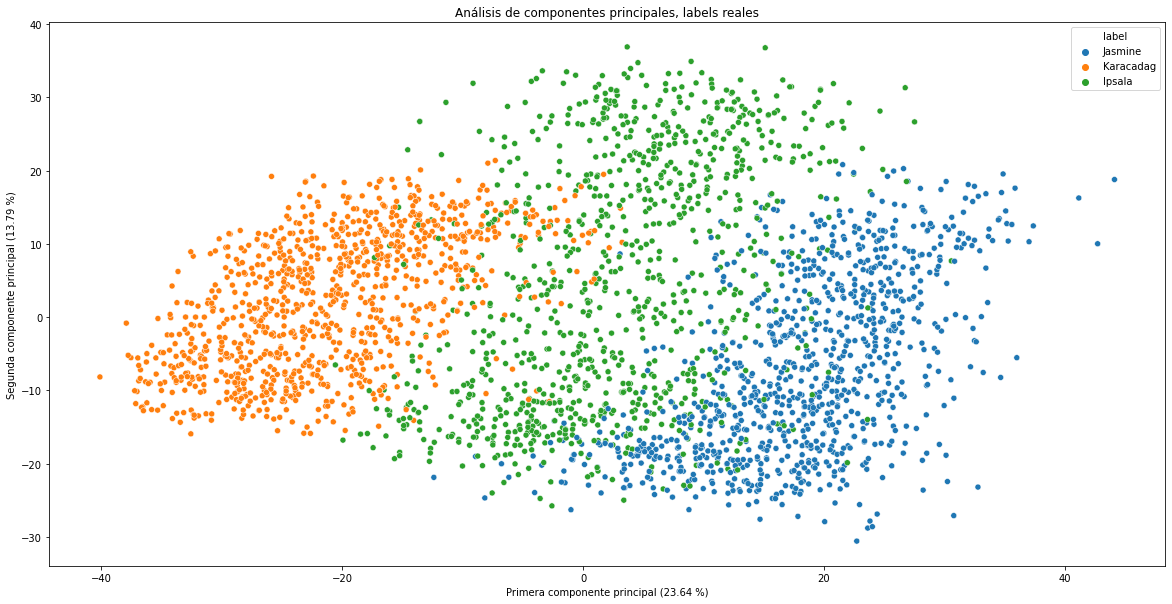

In [191]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

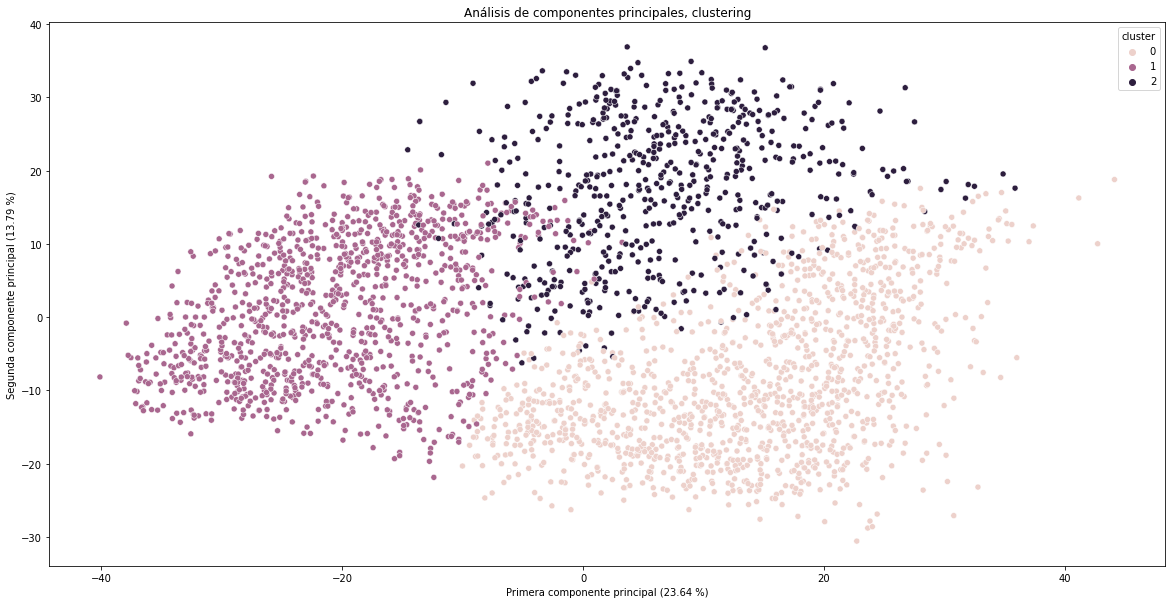

In [192]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# NLTK normalizado euclidean_distance 

In [411]:
scaler = MinMaxScaler()
feat_norm=scaler.fit_transform(feat)

In [412]:
clusterer = KMeansClusterer(num_means=3, distance=euclidean_distance) 
labels_cluster = clusterer.cluster(feat_norm, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [406]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala     508  476   16
Jasmine    621  379    0
Karacadag    4   18  978

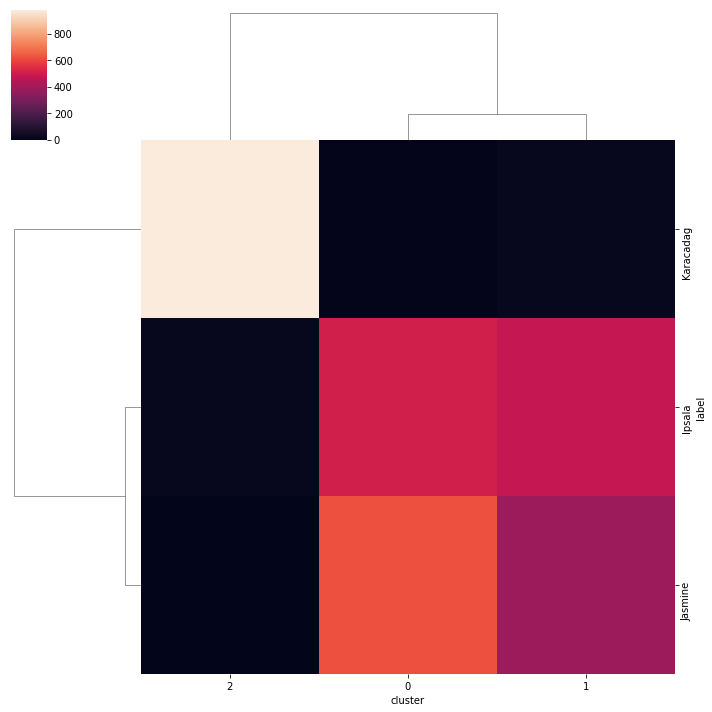

In [407]:
sns.clustermap(confusion)

In [408]:
print(vanDongen(confusion))

0.47013188518231186


In [409]:
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.4781636439976726


In [410]:
silhouette_score(feat_norm, labels_cluster)

0.140938039685082

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


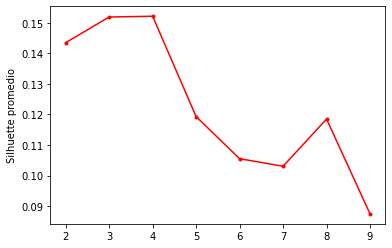

In [383]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat_norm)
    clusterer = KMeansClusterer(num_means=k, distance=euclidean_distance)
    labels_cluster_k = clusterer.cluster(feat_norm, True, trace=True)

    silh.append(silhouette_score(feat_norm,  labels_cluster_k  )) #, metric='precomputed'
    #sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

#plt.plot(range_k,sse,'r.-')
#plt.ylabel('SSE')
#plt.show()

El optimo es 4

In [384]:
clusterer = KMeansClusterer(num_means=4, distance=euclidean_distance) 
labels_cluster = clusterer.cluster(feat_norm, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [385]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala     477    6  507   10
Jasmine    231  759   10    0
Karacadag    3    1    8  988

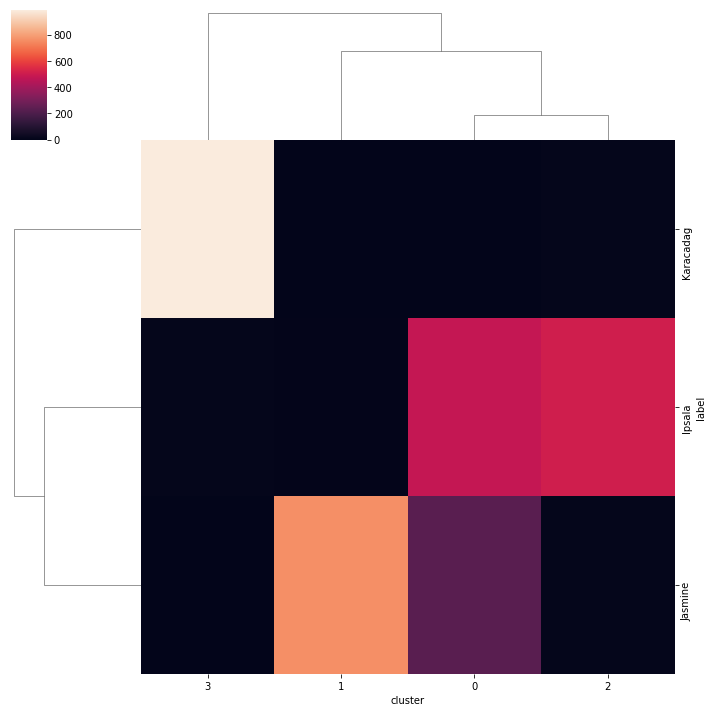

In [386]:
sns.clustermap(confusion)

In [387]:
print(vanDongen(confusion))

0.2536231884057971


In [388]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6874630705305687


In [389]:
silhouette_score(feat_norm, labels_cluster)

0.15211019047719673

# NLTK normalizado cosine_distance 

In [413]:
clusterer = KMeansClusterer(num_means=3, distance=cosine_distance)
labels_cluster = clusterer.cluster(feat_norm, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [414]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala       4   10  986
Jasmine      1  978   21
Karacadag  991    1    8

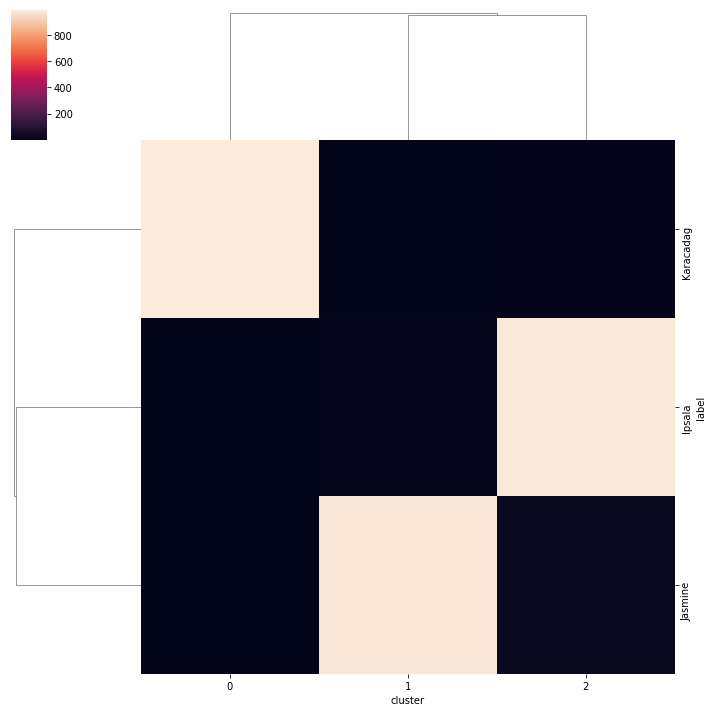

In [415]:
sns.clustermap(confusion)

In [416]:
print(vanDongen(confusion))

0.02258469259723965


In [417]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.955573214262507


In [418]:
silhouette_score(feat, labels_cluster)

0.18014648452054158

In [419]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat_norm)
    clusterer = KMeansClusterer(num_means=k, distance=cosine_distance)
    labels_cluster_k = clusterer.cluster(feat_norm, True, trace=True)

    silh.append(silhouette_score(feat_norm,  labels_cluster_k  )) #, metric='precomputed'
    #sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

#plt.plot(range_k,sse,'r.-')
#plt.ylabel('SSE')
#plt.show()

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration


El optimo es 4

In [398]:
clusterer = KMeansClusterer(num_means=4, distance=cosine_distance)
labels_cluster = clusterer.cluster(feat_norm, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [399]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala     473   10    6  511
Jasmine    231    0  756   13
Karacadag    3  984    0   13

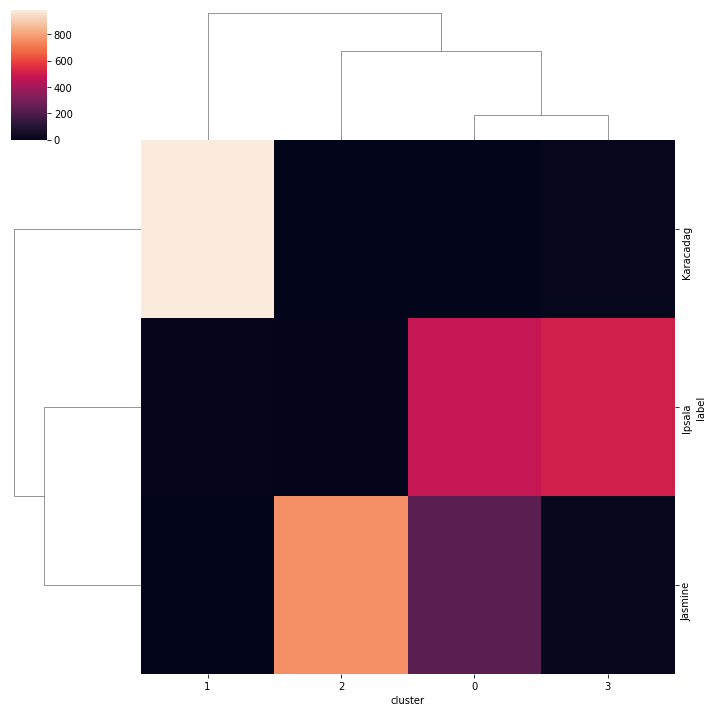

In [400]:
sns.clustermap(confusion)

In [401]:
print(vanDongen(confusion))

0.25586620069895155


In [402]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6827840958832446


In [403]:
silhouette_score(feat_norm, labels_cluster)

0.15180588081028196

# KMEAN max_iter=300

In [201]:
kmeans = KMeans(n_clusters=3, max_iter=300)
kmeans.fit(feat)
labels_cluster=kmeans.labels_

In [202]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [203]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala      21  967   12
Jasmine      3   18  979
Karacadag  987   12    1

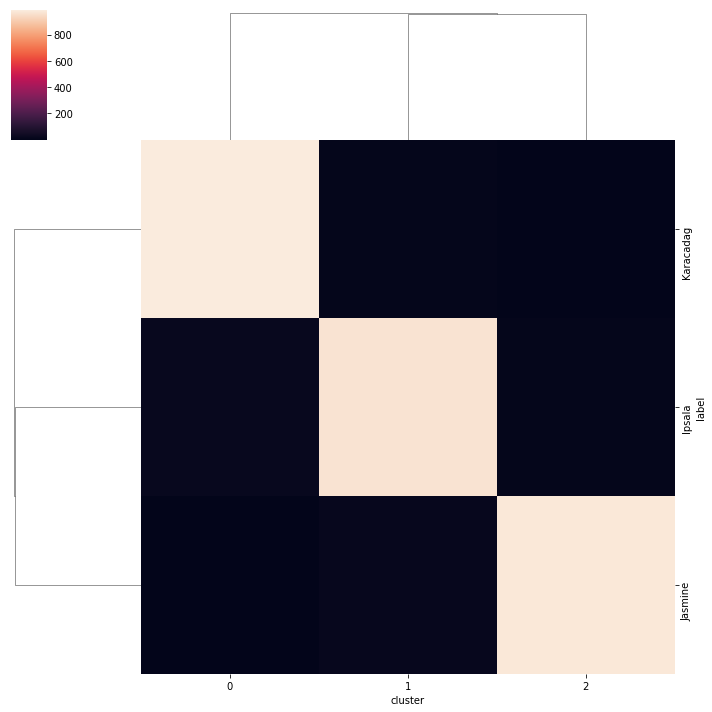

In [204]:
sns.clustermap(confusion)

In [205]:
print(vanDongen(confusion))

0.033592379042366505


In [206]:

print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9342897422871026


In [207]:
silhouette_score(feat, labels_cluster)

0.18038827093311532

In [208]:
kmeans.inertia_

3030041.1739012604

## buscando nro clusters optimo

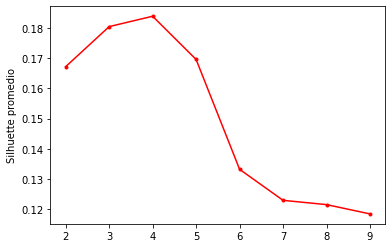

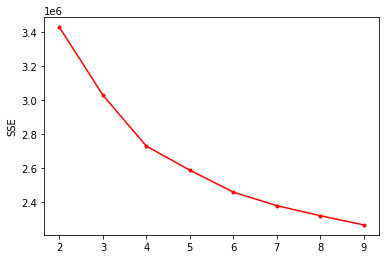

In [209]:
range_k = [i for i in range(2,10)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(feat)

    silh.append(silhouette_score(feat, KM.labels_)) #, metric='precomputed'
    sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

El nro optimo es 4

In [210]:
kmeans = KMeans(n_clusters=4, max_iter=300)
kmeans.fit(feat)
labels_cluster=kmeans.labels_

In [211]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [212]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2    3
label                        
Ipsala     499   11    7  483
Jasmine      7    0  738  255
Karacadag   11  984    2    3

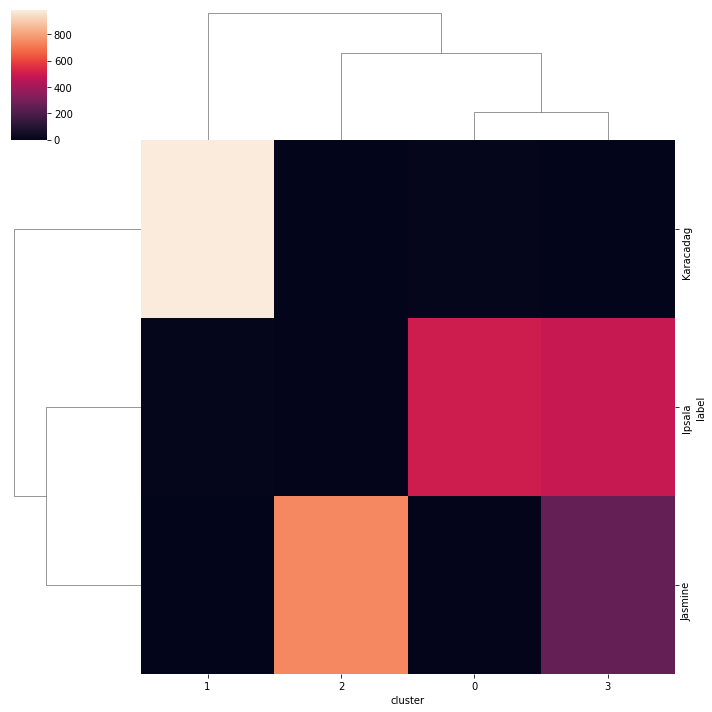

In [217]:
sns.clustermap(confusion)

In [213]:
print(vanDongen(confusion))

0.26841448189762795


In [214]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.6715436221649682


In [215]:
silhouette_score(feat, labels_cluster)

0.18381329729223603

In [216]:
kmeans.inertia_

2730102.642915928

## Visualizacion de cluster usando PCA

In [218]:
pca = PCA(n_components=100, random_state=42)
scores = pca.fit_transform(feat)

dataframe_dict = {'pc1': scores[:,0],
                  'pc2': scores[:,1],
                  'label':list(df["label"]),
                  'cluster': list(labels_cluster)}
df_pca = pd.DataFrame(data = dataframe_dict)

In [219]:
scores .shape

(3000, 100)

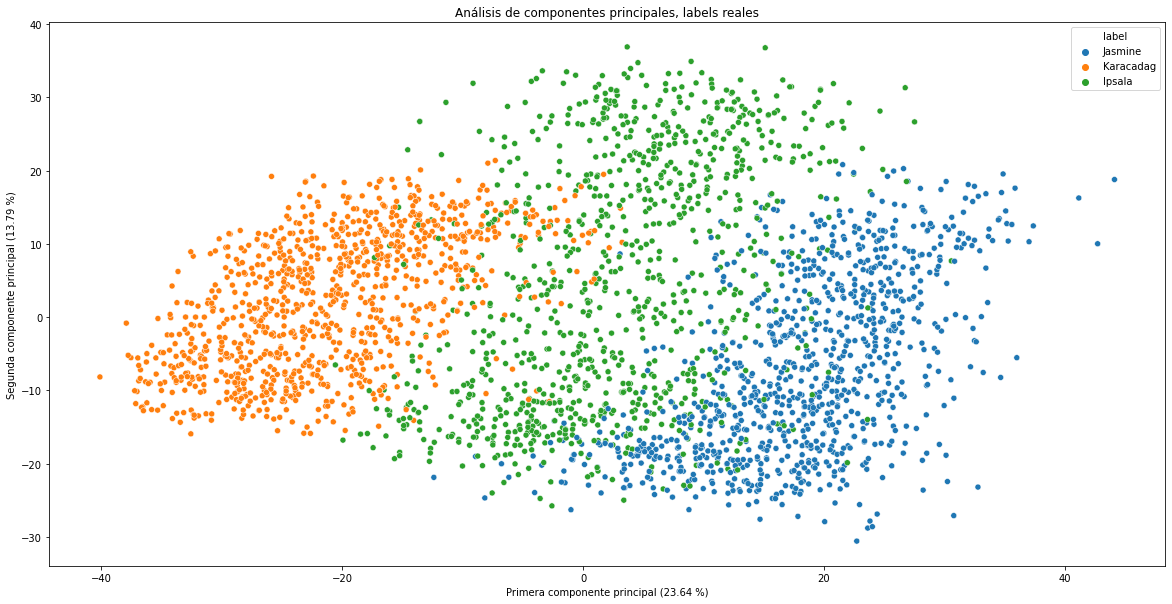

In [220]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="label");
plt.title('Análisis de componentes principales, labels reales')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

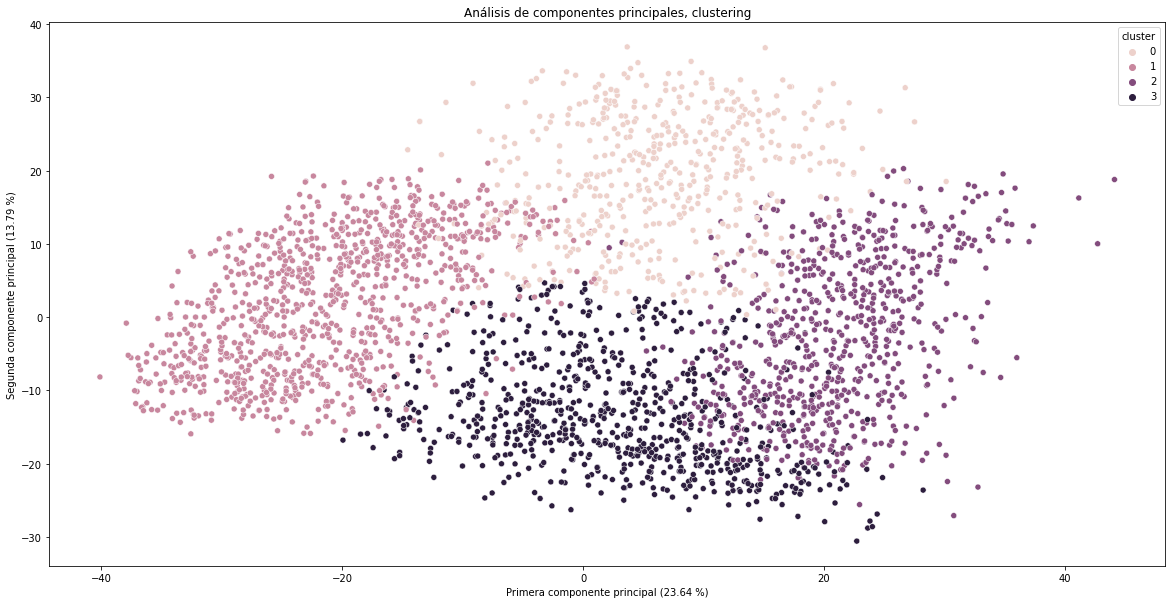

In [221]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="cluster");
plt.title('Análisis de componentes principales, clustering')
plt.xlabel('Primera componente principal (%2.2f %%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('Segunda componente principal (%2.2f %%)'  % (pca.explained_variance_ratio_[1]*100));

# KMEAN max_iter=150

In [223]:
kmeans = KMeans(n_clusters=3, max_iter=150)
kmeans.fit(feat)
labels_cluster=kmeans.labels_

In [224]:
df_conf = df.copy()
df_conf["cluster"] = labels_cluster
df_conf=df_conf[["label", "cluster"]]

In [225]:
confusion=pd.crosstab(df_conf["label"], df_conf["cluster"])
confusion

cluster      0    1    2
label                   
Ipsala      19  969   12
Jasmine      3   19  978
Karacadag  987   12    1

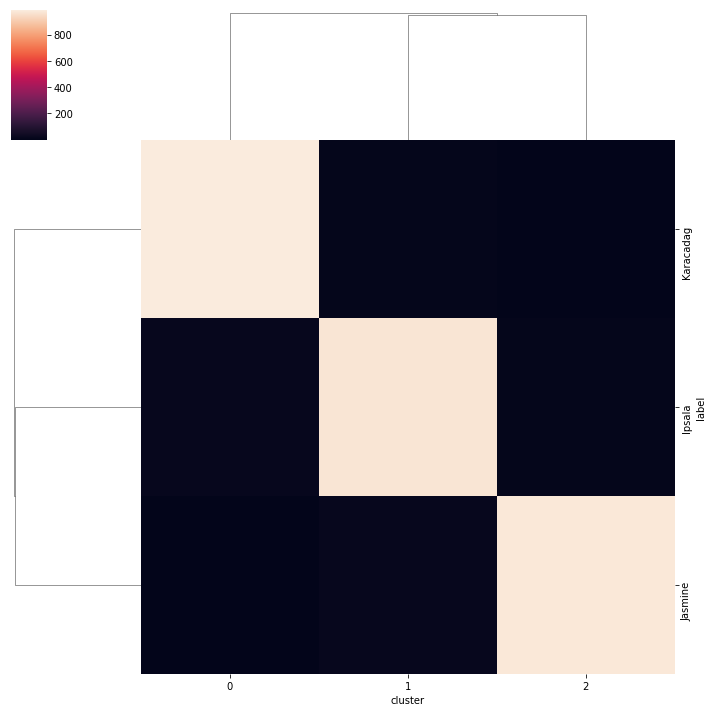

In [226]:
sns.clustermap(confusion)

In [227]:
print(vanDongen(confusion))

0.033074417439238286


In [228]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],labels_cluster)) 

0.9352341838967526


In [229]:
silhouette_score(feat, labels_cluster)

0.18032270832084804

In [230]:
kmeans.inertia_

3030030.204394219